In [ ]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')
%cd  /content/drive/'My Drive'

%pip install bdpy kornia timm tqdm



Mounted at /content/drive
/content/drive/My Drive
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 85 kB 2.8 MB/s 
     |████████████████████████████████| 551 kB 9.9 MB/s 
     |████████████████████████████████| 549 kB 72.1 MB/s 
     |████████████████████████████████| 53 kB 1.8 MB/s 
     |████████████████████████████████| 182 kB 91.6 MB/s 


In [ ]:
import csv
import fnmatch
import glob
import os
from datetime import datetime

import PIL.Image
# import caffe
import lmdb
import numpy as np
import pandas as pd
# from PIL.Image import resize as imresize

import bdpy
import lmdb
import pickle
from torchvision.transforms import Resize
import torchvision.transforms.functional as TF
import torch
from torch.utils.data import Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.transforms.functional import equalize,rgb_to_grayscale
from kornia.enhance import equalize_clahe
import kornia
import matplotlib.pyplot as plt
import timm
import tqdm
from tqdm.autonotebook import tqdm
import itertools
import pickle as pkl
import warnings
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')
torch.set_default_dtype(torch.float64)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device


device(type='cuda')

In [ ]:
class ImageObject:
    def __init__(self, image):
        # Dimensions of image for reconstruction - not really necessary 
        # for this dataset, but some datasets may include images of 
        # varying sizes
        self.channels = image.shape[2]
        self.size = image.shape[:2]
        self.image = image.tobytes()

    def get_image(self):
        """ Returns the image as a numpy array. """
        image = np.frombuffer(self.image, dtype=np.uint8)
        return image.reshape(*self.size, self.channels)
    
    


def create_lmdb(image_dir = "", output_dir = "",image_file_pattern ='*.JPEG', img_size = 248):
    """ Stores images to a LMDB.
        Parameters:
        ---------------
        image       image array, (32, 32, 3) to be stored
        image_id    integer unique ID for image
    """
    if os.path.exists(output_dir):
        print('%s already exists. Skipped.' % output_dir)
    else:
        os.makedirs(output_dir)
        
    image_list = glob.glob(os.path.join(image_dir, image_file_pattern))
    map_size = map_size = 100 * 1024 * len(image_list) * 10 * 10

    # Create a new LMDB environment
    env = lmdb.open(output_dir, map_size=map_size)

    # Start a new write transaction
    with env.begin(write=True) as txn:
        count = 0
        for image_file in image_list:
            image_id = os.path.splitext(os.path.basename(image_file))[0]
            image = PIL.Image.open(image_file)
            image = np.array(image)
             # Monochrome --> RGB
            if image.ndim == 2:
                img_rgb = np.zeros((image.shape[0], image.shape[1], 3), dtype=image.dtype)
                img_rgb[:, :, 0] = image
                img_rgb[:, :, 1] = image
                img_rgb[:, :, 2] = image
                image = img_rgb

            img_obj = ImageObject(image)
            key = image_id
            txn.put(key.encode("ascii"), pickle.dumps(img_obj))
            count = count + 1
            if count %100 == 0:
                print(count)
    env.close()


In [ ]:
# Run once to setup lmdb database
# create_lmdb("data/images/training", "training1")
# create_lmdb("data/images/test", "test1")
#create_lmdb("ArtificialImage", "lmdb_artificial_images", image_file_pattern ='*.tiff')

In [ ]:
from torchvision.utils import ImageFont
import cv2

batch_size = 64
momentum = 0.9
lr = 0.01
epochs = 20
log_interval = 100

class ImageReconstructionDataset(Dataset):

    def __init__(self, X_paths=[], y_path= "",start=0,end=None):
        
    
        
        mris = []
        images = []
        self.env = lmdb.open(y_path)
            
        for path in X_paths:
            fmri_data_bd = bdpy.BData(path)
            # Get fMRI data in the ROI
            fmri_data = fmri_data_bd.select('ROI_VC = 1')

            # Normalize fMRI data
            fmri_data_mean = np.mean(fmri_data, axis=0)
            fmri_data_std = np.std(fmri_data, axis=0)

            fmri_data = (fmri_data - fmri_data_mean) / fmri_data_std
            # fmri_data = fmri_data
            mris.append(torch.from_numpy(fmri_data))

            try:
                fmri_labels = fmri_data_bd.get('Label')[:, 1].flatten()

                # Convet image labels in fMRI data from float to file name labes (str)
                fmri_labels = ['n%08d_%d' % (int(('%f' % a).split('.')[0]),
                                              int(('%f' % a).split('.')[1]))
                                for a in fmri_labels]
            except Exception as e:
                df = pd.read_csv('stimulus_perceptionArtificialImage.tsv',sep = '\t',header=None)
                fmri_labels = fmri_data_bd.get('Label')
                fmri_labels = [df.loc[df[1]==int(a)][0].item()for a in fmri_labels]




                # for label in fmri_labels[:6000]:
                #     image = (pickle.loads(txn.get(label.encode("ascii"))).get_image())
                #     image = torch.from_numpy(image)
                #     image = torch.permute(image, (2,0,1))
                #     images.append(image)

        
        
        self.X = torch.cat(mris)
        if not end:
          end = self.X.shape[0]
        self.X = self.X[start:end]
        self.image_labels = fmri_labels[start:end]
        print(len(self.image_labels))
        # self.y = torch.stack(images)
        self.transform = transforms.Compose([transforms.Resize([128,128]),
                                             
                                transforms.Normalize(mean=[0.0, 0.0, 0.0], std=[1.0, 1.0, 1.0])
                                
                                ])
    
    def __len__(self):
        return self.X.size(0)

    def __getitem__(self, idx):

        image_label = self.image_labels[idx]
        with self.env.begin(write=True) as txn:
            image = pickle.loads(txn.get(image_label.encode())).get_image()
            # path = "data/images/training/" + image_label + ".JPG"
            # print(path)
            # image = cv2.imread("data/images/training/" + image_label + ".JPEG") 
            # if image == None:
                # cv2.imread("data/images/training/" + image_label + ".jpg")
            image = torch.from_numpy(image)
            image = torch.permute(image, (2,0,1))
            image = transforms.functional.convert_image_dtype(image,dtype=torch.float64)
            # image = image.type(torch.float64)
            image = self.transform(image)

        return self.X[idx], image, image_label



In [ ]:
#Natural images data loaders
experiment = "pretrained-autoencoder-mri-natural-images"
pretrained_autoencoder= "autoencoder-naturalimages"
image_h5_paths = ['data/fmri/sub-01_perceptionNaturalImageTraining_original_VC.h5']
                 
natural_images = "training1"
train_dataset = ImageReconstructionDataset(X_paths= image_h5_paths, y_path= natural_images, start=0,end=5500)

trainloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=32, num_workers=10,shuffle=True)

val_dataset = ImageReconstructionDataset(X_paths= image_h5_paths, y_path= natural_images, start=5500,end=5800)

valloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=8, num_workers=2,shuffle=True)

test_dataset = ImageReconstructionDataset(X_paths= image_h5_paths, y_path= natural_images,start=5800,end=None)

testloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=1, num_workers=0, shuffle=True)


5500
300
200


In [ ]:
# Shapes data loaders
experiment = "pretrained-autoencoder-mri-shapes"
pretrained_autoencoder= "autoencoder-shapes-1"


shapes_h5_paths = ['sub-01_perceptionArtificialImage_original_VC.h5']

artificial_shapes = "lmdb_artificial_images"

train_dataset = ImageReconstructionDataset(X_paths= shapes_h5_paths, y_path= artificial_shapes, start=0,end=700)

trainloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=32, num_workers=10,shuffle=True)

val_dataset = ImageReconstructionDataset(X_paths= shapes_h5_paths, y_path= artificial_shapes, start=700,end=750)

valloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=8, num_workers=2,shuffle=True)

test_dataset = ImageReconstructionDataset(X_paths= shapes_h5_paths, y_path= artificial_shapes,start=750,end=None)

testloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=1, num_workers=0, shuffle=True)

700
50
50


torch.Size([3, 128, 128])


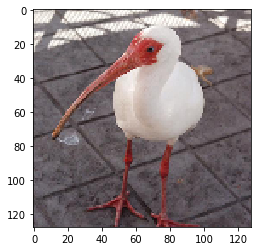

In [ ]:
for batch_idx, (mri, image,label) in enumerate(trainloader):
    print(image[0].shape)
    plt.imshow(image[0].squeeze().permute(1,2,0), interpolation='nearest')
    plt.show()
    break

In [ ]:
class CFG:
    debug = False
    batch_size = 32
    num_workers = 4
    head_lr = 1e-3
    image_encoder_lr = 1e-4
    text_encoder_lr = 1e-5
    weight_decay = 1e-3
    patience = 1
    factor = 0.8
    epochs = 10
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model_name = 'resnet50'
    image_embedding = 2048
    

    pretrained = True # for both image encoder and text encoder
    trainable = True # for both image encoder and text encoder
    temperature = 1.0

    # image size
    size = 224

class AvgMeter:
    def __init__(self, name="Metric"):
        self.name = name
        self.reset()

    def reset(self):
        self.avg, self.sum, self.count = [0] * 3

    def update(self, val, count=1):
        self.count += count
        self.sum += val * count
        self.avg = self.sum / self.count

    def __repr__(self):
        text = f"{self.name}: {self.avg:.4f}"
        return text

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group["lr"]

In [ ]:
class MriEncoder(nn.Module):
    def __init__(self,encode_dim=1024):
        super().__init__()
        
        self.fc = nn.Sequential(
                    nn.Linear(11726, 8192),
                    nn.BatchNorm1d(8192),
                    nn.LeakyReLU(), 
                
                    nn.Linear(8192, 4096),
                    nn.BatchNorm1d(4096),
                    nn.LeakyReLU(),
                    nn.Linear(4096, 2048),
                    nn.BatchNorm1d(2048),
                    nn.LeakyReLU(),
                    nn.Linear(2048, 1024),
                    nn.BatchNorm1d(1024),
                    nn.LeakyReLU(),
                    nn.Linear(1024, 512),
                    nn.BatchNorm1d(512),
                    nn.LeakyReLU(),
                    nn.Linear(512, encode_dim),
                    nn.BatchNorm1d(encode_dim),
                    nn.LeakyReLU(),                  
                    )
        

    def forward(self, input):
        input = self.fc(input)
        return input

In [ ]:
class ImageEncoder(nn.Module):
    """
    Encode images to a fixed size vector
    """

    def __init__(
        self, encode_dim = 1024, model_name='resnet50', pretrained=True, trainable=True
    ):
        super().__init__()
        self.resnet = timm.create_model(
            model_name, pretrained, num_classes=0, global_pool="avg"
        )
        for p in self.resnet.parameters():
            p.requires_grad = trainable


        self.fc1 = nn.Sequential(
                    nn.Linear(2048, 1024),
                    nn.BatchNorm1d(1024),
                    nn.LeakyReLU())
        
        self.fc2 = nn.Sequential(
                    nn.Linear(1024, encode_dim),
                    nn.BatchNorm1d(1024),
                    nn.LeakyReLU())


    def forward(self, x):
        # x = x.type(torch.float64).to(device)
        x = self.resnet(x)
        x = self.fc1(x)
        x = self.fc2(x)
        return x

In [ ]:
class ImageDecoder(nn.Module):
    """
    Reconstrcut images from embeddings
    """

    def __init__(
        self, encode_dim = 1024, model_name='resnet50', pretrained=True, trainable=True
    ):
        super().__init__()
        

        self.fc1 = nn.Sequential(
                    nn.Linear(encode_dim, 1024),
                    nn.BatchNorm1d(1024),
                    nn.LeakyReLU())
        

        self.fc2 = nn.Sequential(
                    nn.Linear(1024, 64 * 4 * 4),
                    nn.BatchNorm1d(64*4*4),
                    nn.LeakyReLU())
        
        self.conv1 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=3, stride=2,
                               padding=0),
            nn.BatchNorm2d(32, momentum=0.01),
            nn.LeakyReLU(inplace=True),
        )
        self.conv2 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=32, out_channels=8, kernel_size=3, stride=2,
                               padding=0),
            nn.BatchNorm2d(8, momentum=0.01),
            nn.LeakyReLU(inplace=True),
        )

        self.conv3 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=8, out_channels=3, kernel_size=3, stride=2,
                               padding=0),
            nn.BatchNorm2d(3, momentum=0.01),
            nn.LeakyReLU()   
        )

        self.conv3 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=8, out_channels=3, kernel_size=3, stride=2,
                               padding=0),
            nn.BatchNorm2d(3, momentum=0.01),
            nn.LeakyReLU()   
        )
        
        self.conv3 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=8, out_channels=3, kernel_size=3, stride=2,
                               padding=0),
            nn.BatchNorm2d(3, momentum=0.01),
            nn.Sigmoid()   
        )

    def forward(self, x):
        x = self.fc1(x)
        x = self.fc2(x).view(-1, 64, 4, 4)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = F.interpolate(x, size=(128, 128), mode='bilinear')
        return x

In [ ]:
img_encoder = ImageEncoder().to(device)
img_decoder = ImageDecoder().to(device)
mri_encoder = MriEncoder().to(device)

img_encoder.load_state_dict(torch.load("img_encoder_{0}.pt".format(pretrained_autoencoder), map_location=CFG.device))
img_decoder.load_state_dict(torch.load("img_decoder_{0}.pt".format(pretrained_autoencoder), map_location=CFG.device))
# mri_encoder.load_state_dict(torch.load("best-mri-encoder-shapes.pt", map_location=CFG.device))


Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-rsb-weights/resnet50_a1_0-14fe96d1.pth" to /root/.cache/torch/hub/checkpoints/resnet50_a1_0-14fe96d1.pth


<All keys matched successfully>

In [ ]:
params = [
    {"params": mri_encoder.parameters(), "lr": 0.01},
    # {"params": img_decoder.parameters(), "lr": 0.01}
]
optimizer = torch.optim.Adam(params, weight_decay=0.)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="min", patience=CFG.patience, factor=CFG.factor
)
step = "epoch"
epochs = 10

In [ ]:
# Training
print("Training {0}".format(experiment))
best_loss = float('inf')
metrics = []
print(range(epochs))
for epoch in range(epochs):
    print(f"Epoch: {epoch + 1}")
    mri_encoder.train()
    img_decoder.eval()
    img_encoder.eval()
    loss_meter = AvgMeter()
    tqdm_object = tqdm(trainloader, total=len(trainloader))
    for mris,images,labels in tqdm_object:
        mris,images = mris.to(device),images.to(device)
        mri_embeddings = mri_encoder(mris)
        img_embeddings = img_encoder(images)
        recon_imgs = img_decoder(mri_embeddings)
        optimizer.zero_grad()
        
        loss1 = nn.MSELoss()(images,recon_imgs)
        loss2 = nn.MSELoss()(img_embeddings,mri_embeddings)
        loss = loss1 +loss2
        loss.backward()
        optimizer.step()
        if step == "batch":
            lr_scheduler.step()

        count = images.shape[0]
        loss_meter.update(loss.item(), count)
        tqdm_object.set_postfix(train_loss=loss_meter.avg)


    valid_loss_meter = AvgMeter()

    valid_tqdm_object = tqdm(valloader, total=len(valloader))
    for mris,images,labels in valid_tqdm_object:
        mris,images = mris.to(device),images.to(device)
        mri_embeddings = mri_encoder(mris)
        img_embeddings = img_encoder(images)
        recon_imgs = img_decoder(mri_embeddings)        
        valid_loss1 = nn.MSELoss()(images,recon_imgs)
        valid_loss2 = nn.MSELoss()(img_embeddings,mri_embeddings)
        valid_loss = valid_loss1 + valid_loss1
        valid_loss = valid_loss1 + valid_loss2
        count = images.size(0)
        valid_loss_meter.update(valid_loss.item(), count)
        valid_tqdm_object.set_postfix(valid_loss=valid_loss_meter.avg)

    if valid_loss_meter.avg < best_loss:
        best_loss = valid_loss_meter.avg
        torch.save(mri_encoder.state_dict(), "mri_encoder_{0}.pt".format(experiment))
        # torch.save(img_decoder.state_dict(), "img_decoder_{0}.pt".format(experiment))
        print("Saved Best Model!")

    lr_scheduler.step(valid_loss_meter.avg)    
    metrics.append((epoch,loss_meter.avg ,valid_loss_meter.avg))

with open('metrics_{0}.pkl'.format(experiment), 'wb') as f:       #this will save the list as "results.pkl" which you can load in later 
    pkl.dump(metrics, f)


torch.save(mri_encoder.state_dict(), "mri_encoder_{0}_final.pt".format(experiment))
# torch.save(img_decoder.state_dict(), "img_decoder_{0}_final.pt".format(experiment))
print("Saved Best Model!")

    

Training pretrained-autoencoder-mri-natural-images
range(0, 10)
Epoch: 1


  0%|          | 0/172 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

Saved Best Model!
Epoch: 2


  0%|          | 0/172 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

Saved Best Model!
Epoch: 3


  0%|          | 0/172 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

Epoch: 4


  0%|          | 0/172 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

Epoch: 5


  0%|          | 0/172 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

Epoch: 6


  0%|          | 0/172 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

Epoch: 7


  0%|          | 0/172 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

Epoch: 8


  0%|          | 0/172 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

Epoch: 9


  0%|          | 0/172 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

Epoch: 10


  0%|          | 0/172 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

Saved Best Model!
Saved Best Model!


  0%|          | 0/200 [00:00<?, ?it/s]

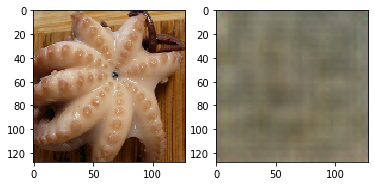

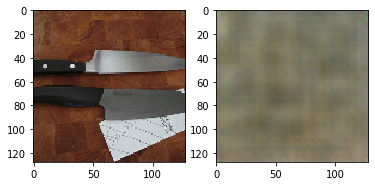

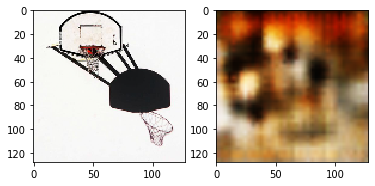

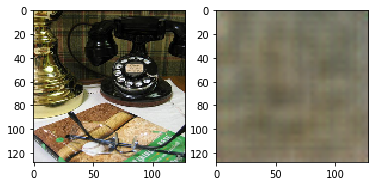

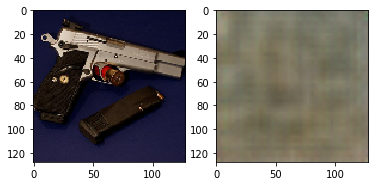

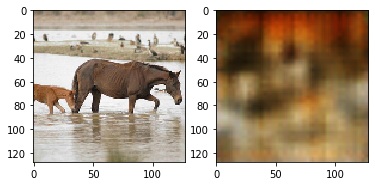

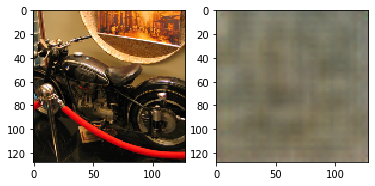

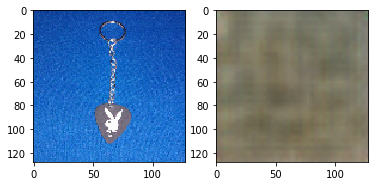

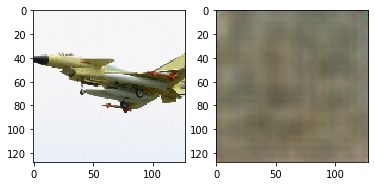

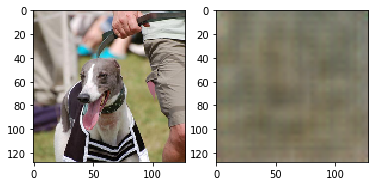

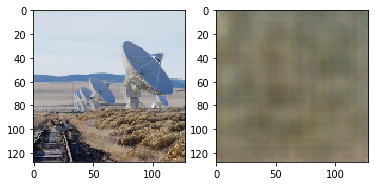

In [ ]:
best_img_decoder = img_decoder
best_mri_encoder = mri_encoder
show_img_count = 10
# best_img_decoder = ImageDecoder().to(device)
# best_mri_encoder = MriEncoder().to(device)

# best_img_decoder.load_state_dict(torch.load("img_decoder_{0}.pt".format(experiment), map_location=CFG.device))
# best_mri_encoder.load_state_dict(torch.load("mri_encoder_{0}.pt".format(experiment), map_location=CFG.device))


best_img_decoder.eval()
best_mri_encoder.eval()

count =0
with torch.no_grad():
    tqdm_object = tqdm(testloader, total=len(testloader))
    for mris,images,labels in tqdm_object:
        mris,images = mris.to(device),images.to(device)
        mri_embeddings = best_mri_encoder(mris)
        recon_imgs = best_img_decoder(mri_embeddings)
        f, axarr = plt.subplots(1,2)
        axarr[0].imshow(images[0].squeeze().cpu().detach().squeeze().permute(1,2,0), interpolation='nearest')
        axarr[1].imshow(recon_imgs[0].cpu().detach().squeeze().permute(1,2,0), interpolation='nearest')
        plt.show()
        count = count + 1
        if count > show_img_count:
          break

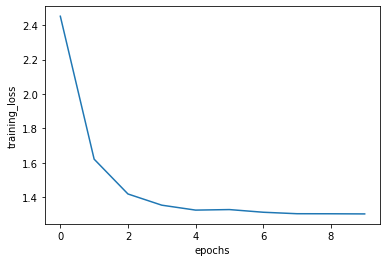

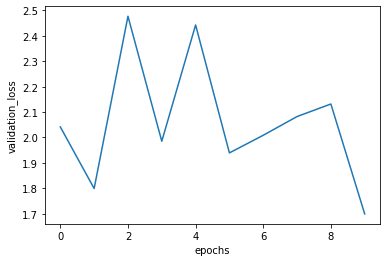

In [ ]:
import pandas as pd
with open('metrics_{0}.pkl'.format(experiment), 'rb') as f:
    metrics = pkl.load(f)
    df = pd.DataFrame(metrics, columns =['epoch', 'training_loss', 'validation_loss'])
    plt.plot(df["epoch"], df["training_loss"])
    plt.xlabel("epochs")
    plt.ylabel("training_loss")
    plt.show()
    plt.plot(df["epoch"], df["validation_loss"])
    plt.xlabel("epochs")
    plt.ylabel("validation_loss")
    plt.show()
